### Setting the feelpp environment


In [ ]:
import sys
import feelpp
import feelpp.toolboxes.core as tb
from tools.Poisson import Poisson, runLaplacianPk, runConvergenceAnalysis, plot_convergence, custom_cmap

sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h

P = Poisson(dim = 2)



In [ ]:
P(solver="scimba")

### Examples with different parameters

Solving the laplacian problem for h = 0.0125...
generate mesh omega-2.geo with h=0.0125 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.0125 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                                                            |
| | Environment                       

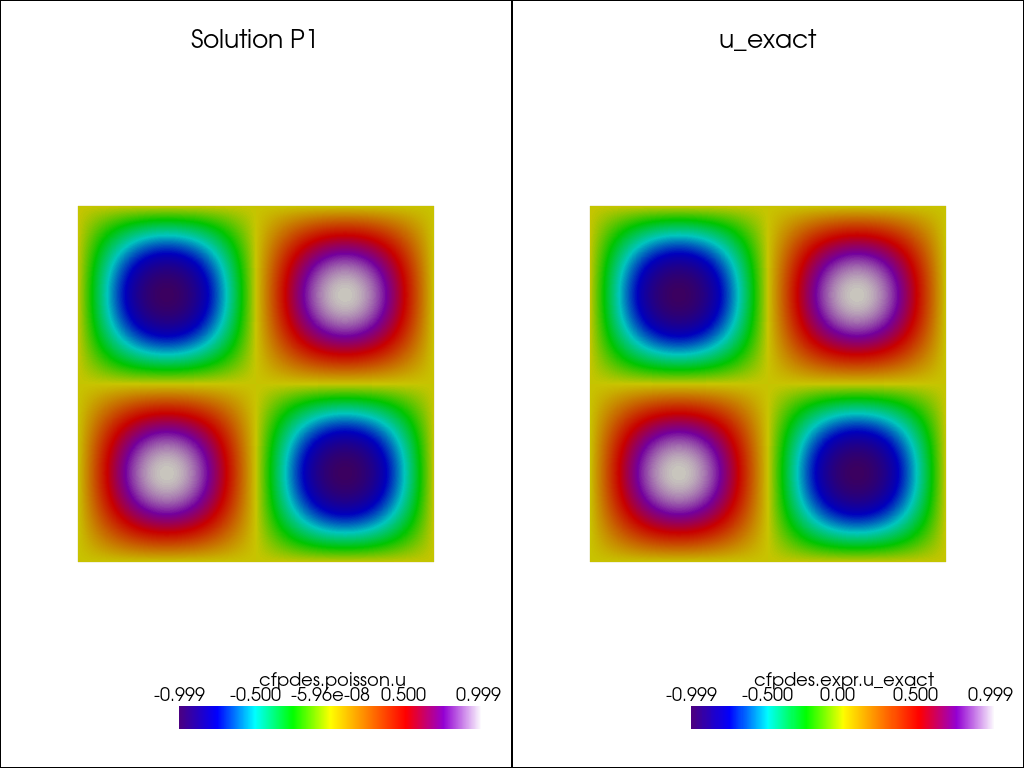

Solving a Poisson problem for h = 0.0125...
>> load network /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.08e+04
epoch     0: best loss = 1.08e+04
epoch     1: best loss = 4.04e+03
epoch     2: best loss = 2.10e+02
epoch     6: best loss = 1.99e+02
epoch     9: best loss = 1.32e+02
epoch    10: best loss = 4.82e+01
epoch    14: best loss = 3.35e+01
epoch    15: best loss = 2.72e+01
epoch    20: best loss = 1.19e+01
epoch    21: best loss = 9.13e+00
epoch    27: best loss = 1.22e-01
epoch    54: best loss = 4.20e-02
epoch    67: best loss = 2.78e-02
epoch    73: best loss = 2.73e-02
epoch    79: best loss = 2.72e-02
epoch    85: best loss = 2.28e-02
epoch    91: best loss = 1.87e-02
epoch    97: best loss = 1.53e-02
epoch    99: current loss = 4.61e-02
load network: /workspaces/2024-stage-feelpp-scimba/feelppdb/feelpp_cfpde/np_1/networks/test.pth
jsbdbshd
network loaded


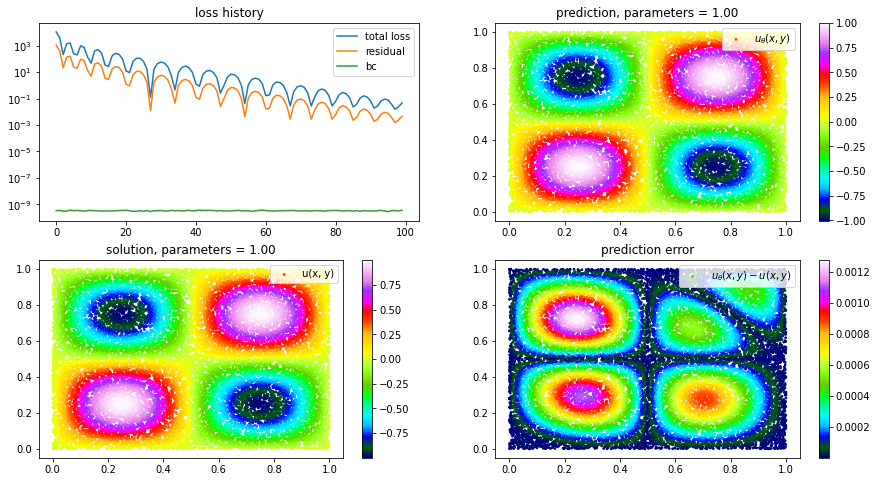

                          0
0  cfpdes.expr.grad_u_exact
1           cfpdes.expr.rhs
2       cfpdes.expr.u_exact
3          cfpdes.poisson.u
Number of features in coordinates: 3
Number of points: 7554

Nodes from export.case: [[0.32009158 0.0112713 ]
 [0.33214724 0.01079619]
 [0.32754993 0.02345362]
 ...
 [0.01827418 0.2125    ]
 [0.29523468 0.991313  ]
 [0.52455205 0.01731404]]

Feel++ solution 'cfpdes.poisson.u':
[ 0.06407735  0.05894985  0.12982139 ...  0.11136749 -0.05236771
 -0.0166978 ]
Shape of input tensor (coordinates): torch.Size([7554, 2])
u( tensor([0.3201, 0.0113]) ) = 0.06402818273555315
u( tensor([0.3321, 0.0108]) ) = 0.05897115771952349
u( tensor([0.3275, 0.0235]) ) = 0.1297902497409328
u( tensor([0.8272, 0.0251]) ) = -0.13908490634154844
u( tensor([0.8167, 0.0188]) ) = -0.1078183376363784
u( tensor([0.8293, 0.0119]) ) = -0.06554659105505396
u( tensor([0.8918, 0.0251]) ) = -0.09862004589372592
u( tensor([0.8796, 0.0210]) ) = -0.09036834124231913
u( tensor([0.8932, 0.0111

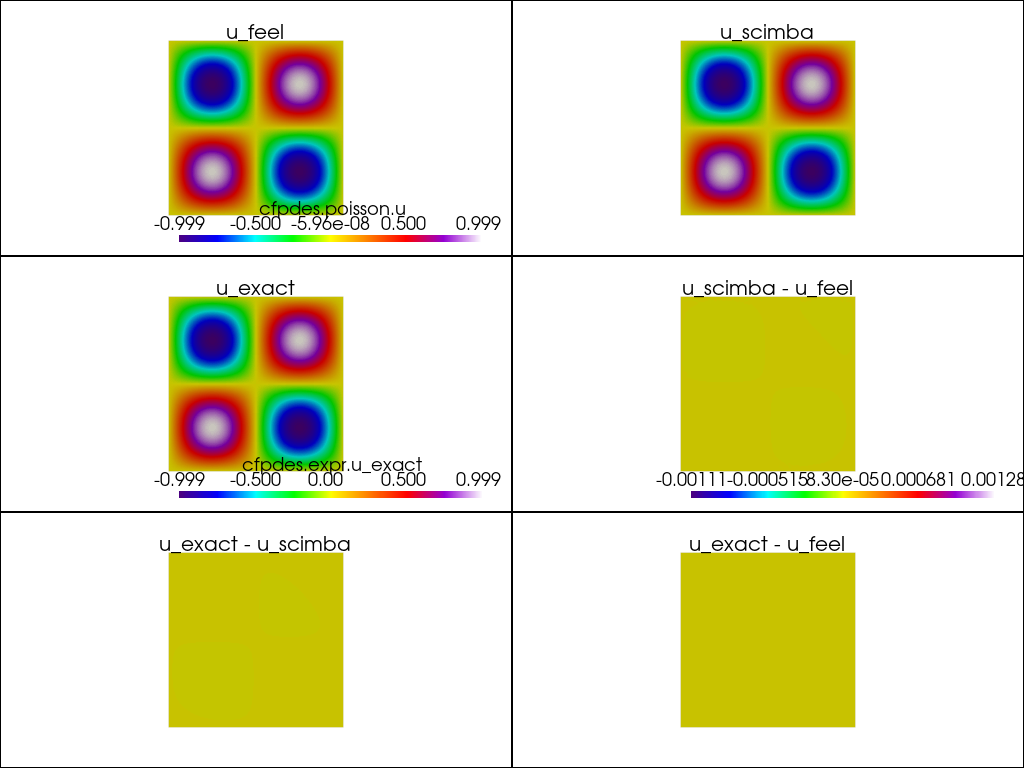

In [3]:

# for square domain

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(h=0.0125 ,rhs=rhs, g='0', solver ='scimba', u_exact = u_exact)


In [ ]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2', g='y', solver ='scimba', u_exact = u_exact)


In [ ]:

u_exact = '-y*y*0.5 - x*y*y*y*0.5 + y*y*y*y*0.25'
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', solver ='scimba', u_exact = u_exact)

In [ ]:
# for disk domain

u_exact = 'sin(pi*(x*x + y*y))'
rhs = '-4*pi*cos(pi*(x*x + y*y)) + 4*pi*pi*(x*x + y*y)*sin(pi*(x*x + y*y))'

P(rhs=rhs, g='0', shape='Disk', solver='scimba', u_exact=u_exact)


In [ ]:
u_exact =  '(1 - x*x - y*y)'
rhs = '4'

P(rhs=rhs, g= '0', shape= 'Disk', solver='scimba', u_exact = u_exact)

### Computing errors

In [ ]:
# Collect data to compute errors
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
grad_u_exact = '{2*pi*cos(2*pi*x) * sin(2*pi*y), 2*pi*sin(2*pi*x) * cos(2*pi*y)}'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

h= [0.1, 0.05, 0.025, 0.0125, 0.00625]
measures = []

for i in h:
  P(h=i, rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact = grad_u_exact)
  measures.append(P.measures)

print("this is the measures = ", measures)

# Plotting the error convergence rates
poisson_json = P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2, hs= h,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()


In [ ]:
# Collect data to compute errors
u_exact =  '(1 - x*x - y*y)'
grad_u_exact = '{-2*x, -2*y}'
rhs = '4'

h= [0.1, 0.05, 0.025, 0.0125, 0.00625]
measures = []

P(h=0.1, rhs=rhs, g='0',shape= 'Disk', u_exact = u_exact, grad_u_exact = grad_u_exact)
#measures.append(P.measures)
print("this is the measures = ", P.measures)

P(h=0.0125, rhs=rhs, g='0',shape= 'Disk', u_exact = u_exact, grad_u_exact = grad_u_exact)
print("this is the measures = ", P.measures)
"""
# Plotting the error convergence rates
poisson_json = P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2, hs= h,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""

In [ ]:
# Collect data to compute errors
u_exact = 'y + (x*(1-x) + y*(1-y)*0.25) '
grad_u_exact = '{1-2*x, 1.25 - 0.5*y}'
rhs='2.5'

h= [0.1, 0.05, 0.025, 0.0125, 0.00625]
measures = []

for i in h:
  P(h=i, rhs=rhs, g='0', plot = None, u_exact = u_exact, grad_u_exact=grad_u_exact)
  measures.append(P.measures)

print(measures)

# Plotting the error convergence rates

poisson_json = P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2, hs= h,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()

In [ ]:
# Collect data to compute errors

u_exact =  'sin(pi*(x*x + y*y))'
grad_u_exact = '{2*pi*x*cos(pi*(x*x + y*y)), 2*pi*y*cos(pi*(x*x + y*y))}'
rhs = '-4*pi*cos(pi*(x*x + y*y)) + 4*pi*pi*(x*x + y*y)*sin(pi*(x*x + y*y))'

h= [0.1, 0.05, 0.025, 0.0125, 0.00625]
measures = []
for i in h:
  P(h=i, rhs=rhs, g='0', plot=None , shape= 'Disk', u_exact = u_exact, grad_u_exact = grad_u_exact)
  measures.append(P.measures)

print('measures = ', measures)

# Plotting the error convergence rates
poisson_json = P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2, hs= h, verbose=True)
fig= plot_convergence(P, df,dim=2)
fig.show()

In [ ]:
u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
grad_u_exact = '{1-2*x, 0.25 - 0.5*y}'
rhs = '5/2'

h= [0.1, 0.05, 0.025, 0.0125, 0.00625]
measures = []
for i in h:
  P(h=i, rhs=rhs, g='0', plot=None , u_exact = u_exact, grad_u_exact = grad_u_exact)
  measures.append(P.measures)

print('measures = ', measures)

# Plotting the error convergence rates
poisson_json = P.model
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2, hs= h, verbose=True)
fig= plot_convergence(P, df,dim=2)
fig.show()

In [ ]:

"""
# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='feelpp', u_exact = u_exact)
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='scimba', u_exact = u_exact)

u_exact = 'x*x + y*y'
P(rhs='4', diff='{x,y,-y,x+y}', g='x*x + y*y',  solver='feelp', u_exact = u_exact)

poisson_json = lambda order,dim=2,name="u": P.model
print(poisson_json(dim=2,order=1))
df= runConvergenceAnalysis( P, json=poisson_json, measures=measures, dim=2,verbose=True)
print('measures = ', measures)
fig= plot_convergence(P, df,dim=2)
fig.show()
"""
